In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime as dt
import random

In [2]:
pd.set_option('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None)
pd.options.mode.chained_assignment = None

In [3]:
config = "1tls_3x3"

In [4]:
df_dqn_con = pd.read_csv(f'./{config}/con/DuelingDoubleDQNAgent_lr0.0001.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_con', con=True)
df_maxpressure_con = pd.read_csv(f'./{config}/con/MaxPressureBaseline.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_con', con=True)
df_sotl_con = pd.read_csv(f'./{config}/con/SotlBaseline.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_con', con=True)
df_uniform_con = pd.read_csv(f'./{config}/con/UniformBaseline.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_con', con=True)
df_dqn_def = pd.read_csv(f'./{config}/def/DuelingDoubleDQNAgent_lr0.0001.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_def', con=False)
df_maxpressure_def = pd.read_csv(f'./{config}/def/MaxPressureBaseline.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_def', con=False)
df_sotl_def = pd.read_csv(f'./{config}/def/SotlBaseline.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_def', con=False)
df_uniform_def = pd.read_csv(f'./{config}/def/UniformBaseline.csv', delimiter=',').assign(id_con=lambda df: df['id']+'_def', con=False)
None

In [5]:
dfs = [df_dqn_con, df_maxpressure_con, df_sotl_con, df_uniform_con, 
       df_dqn_def, df_maxpressure_def, df_sotl_def, df_uniform_def]

In [6]:
for df in dfs:
    display(df.loc[df["done"] == True].head(2))

,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
299,300,84.738664,rlcontroller,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",37,30.508629,3763.0,3911.0,22,0.824558,101.702703,105.702703,1.833333,False,True,rlcontroller_con,True
617,318,114.218432,rlcontroller,2,0.1,0.1,"[200.0, 200.0, 600.0, 300.0]",81,73.429016,7054.0,10402.0,52,0.906531,87.086420,128.419753,4.333333,False,True,rlcontroller_con,True


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
263,264,0.0,maxpressurebaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",27,19.034108,464.0,512.0,12,0.704967,17.185185,18.962963,1.000000,False,True,maxpressurebaseline_con,True
545,282,0.0,maxpressurebaseline,2,0.1,0.1,"[200.0, 200.0, 600.0, 300.0]",41,34.096772,4592.0,4592.0,28,0.831629,112.000000,112.000000,2.333333,False,True,maxpressurebaseline_con,True


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
292,293,0.0,sotlbaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",189,183.000498,4860.0,86481.0,144,0.968257,25.714286,457.571429,12.00,False,True,sotlbaseline_con,True
611,319,0.0,sotlbaseline,2,0.1,0.1,"[200.0, 200.0, 600.0, 300.0]",117,112.412626,1165.0,33981.0,81,0.960792,9.957265,290.435897,6.75,False,True,sotlbaseline_con,True


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
239,240,0.0,uniformbaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",110,102.707175,2078.0,17894.0,87,0.933702,18.890909,162.672727,7.250000,False,True,uniformbaseline_con,True
479,240,0.0,uniformbaseline,2,0.1,0.1,"[200.0, 200.0, 600.0, 300.0]",94,89.115024,1436.0,17050.0,71,0.948032,15.276596,181.382979,5.916667,False,True,uniformbaseline_con,True


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
287,288,90.115140,rlcontroller,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",25,17.236500,3400.0,3428.0,10,0.689460,136.000000,137.120000,0.833333,False,True,rlcontroller_def,False
579,292,114.453611,rlcontroller,2,1.0,0.1,"[200.0, 200.0, 600.0, 300.0]",30,24.183742,913.0,937.0,19,0.806125,30.433333,31.233333,1.583333,False,True,rlcontroller_def,False


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
253,254,0.0,maxpressurebaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",21,12.868570,342.0,345.0,7,0.612789,16.285714,16.428571,0.583333,False,True,maxpressurebaseline_def,False
498,245,0.0,maxpressurebaseline,2,1.0,0.1,"[200.0, 200.0, 600.0, 300.0]",19,12.665879,160.0,160.0,7,0.666625,8.421053,8.421053,0.583333,False,True,maxpressurebaseline_def,False


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
265,266,0.0,sotlbaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",139,128.723890,1388.0,19946.0,76,0.926071,9.985612,143.496403,6.333333,False,True,sotlbaseline_def,False
542,277,0.0,sotlbaseline,2,1.0,0.1,"[200.0, 200.0, 600.0, 300.0]",102,96.681794,1474.0,28866.0,75,0.947861,14.450980,283.000000,6.250000,False,True,sotlbaseline_def,False


,l,r,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,TimeLimit.truncated,done,id_con,con
239,240,0.0,uniformbaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",110,102.707175,2078.0,17894.0,87,0.933702,18.890909,162.672727,7.250000,False,True,uniformbaseline_def,False
479,240,0.0,uniformbaseline,2,1.0,0.1,"[200.0, 200.0, 600.0, 300.0]",94,89.115024,1436.0,17050.0,71,0.948032,15.276596,181.382979,5.916667,False,True,uniformbaseline_def,False


In [7]:
def sum_ep(df):
    return pd.merge(
        df[['id', 'ep', 'veh_n', 'sum_delay', 'sum_waiting_time', 'sum_acc_waiting_time', 'sum_queue_length']].groupby(['ep']).sum(),
        df[['id', 'ep', 'con_p_rate', 'ctrl_con_p_rate', 'veh_n_p_hour', 'id_con', 'con']].groupby(['ep']).apply(lambda df: df.head(1)),
        how='left', left_index=True, right_index=True
    ).reset_index(drop=True)

def sum_df_ep(dfs):
    return pd.concat([sum_ep(df) for df in dfs]).sort_values(['ep', 'id']).reset_index(drop=True)

In [8]:
def avg_ep(df):
    return pd.merge(
        df[['id', 'ep', 'veh_n', 'avg_delay', 'avg_waiting_time', 'avg_acc_waiting_time', 'avg_queue_length']].groupby(['ep']).mean(),
        df[['id', 'ep', 'con_p_rate', 'ctrl_con_p_rate', 'veh_n_p_hour', 'id_con', 'con']].groupby(['ep']).apply(lambda df: df.head(1)),
        how='left', left_index=True, right_index=True
    ).reset_index(drop=True)

def avg_df_ep(dfs):
    return pd.concat([avg_ep(df) for df in dfs]).sort_values(['ep', 'id']).reset_index(drop=True)

In [9]:
sum_df = sum_df_ep(dfs)
avg_df = avg_df_ep(dfs)

In [10]:
display(sum_df.head(16))
display(avg_df.head(16))

,veh_n,sum_delay,sum_waiting_time,sum_acc_waiting_time,sum_queue_length,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,id_con,con
0,7452,5476.671238,162262.0,178248.0,3218,maxpressurebaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",maxpressurebaseline_con,True
1,6439,4552.622860,121834.0,129168.0,2452,maxpressurebaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",maxpressurebaseline_def,False
2,12231,9974.559985,639475.0,750501.0,6944,rlcontroller,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",rlcontroller_con,True
3,9792,7619.617137,484093.0,563542.0,4944,rlcontroller,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",rlcontroller_def,False
4,39477,37596.127634,1260712.0,12139854.0,28667,sotlbaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",sotlbaseline_con,True
5,26003,24214.236350,339909.0,3818007.0,17467,sotlbaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",sotlbaseline_def,False
6,21163,19630.189134,287377.0,3356150.0,14062,uniformbaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",uniformbaseline_con,True
7,21163,19630.189134,287377.0,3356150.0,14062,uniformbaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",uniformbaseline_def,False
8,10442,8703.617460,721067.0,913298.0,6410,maxpressurebaseline,2,0.1,0.1,"[200.0, 200.0, 600.0, 300.0]",maxpressurebaseline_con,True
9,5279,3767.266705,45858.0,54008.0,2033,maxpressurebaseline,2,1.0,0.1,"[200.0, 200.0, 600.0, 300.0]",maxpressurebaseline_def,False


,veh_n,avg_delay,avg_waiting_time,avg_acc_waiting_time,avg_queue_length,id,ep,con_p_rate,ctrl_con_p_rate,veh_n_p_hour,id_con,con
0,28.227273,0.730131,20.665455,22.709182,1.015783,maxpressurebaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",maxpressurebaseline_con,True
1,25.350394,0.703312,18.116445,19.225712,0.804462,maxpressurebaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",maxpressurebaseline_def,False
2,40.770000,0.807624,51.657742,60.116116,1.928889,rlcontroller,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",rlcontroller_con,True
3,34.000000,0.771721,49.240486,57.294971,1.430556,rlcontroller,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",rlcontroller_def,False
4,134.733788,0.930051,26.939998,253.778617,8.153299,sotlbaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",sotlbaseline_con,True
5,97.755639,0.907000,12.063332,123.209393,5.472118,sotlbaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",sotlbaseline_def,False
6,88.179167,0.909160,12.994183,140.100095,4.882639,uniformbaseline,1,0.3,0.3,"[1000.0, 200.0, 500.0, 200.0]",uniformbaseline_con,True
7,88.179167,0.909160,12.994183,140.100095,4.882639,uniformbaseline,1,1.0,0.3,"[1000.0, 200.0, 500.0, 200.0]",uniformbaseline_def,False
8,37.028369,0.819691,58.770887,74.880698,1.894208,maxpressurebaseline,2,0.1,0.1,"[200.0, 200.0, 600.0, 300.0]",maxpressurebaseline_con,True
9,21.546939,0.708888,8.474306,9.893084,0.691497,maxpressurebaseline,2,1.0,0.1,"[200.0, 200.0, 600.0, 300.0]",maxpressurebaseline_def,False


In [11]:
###################################################################################################################

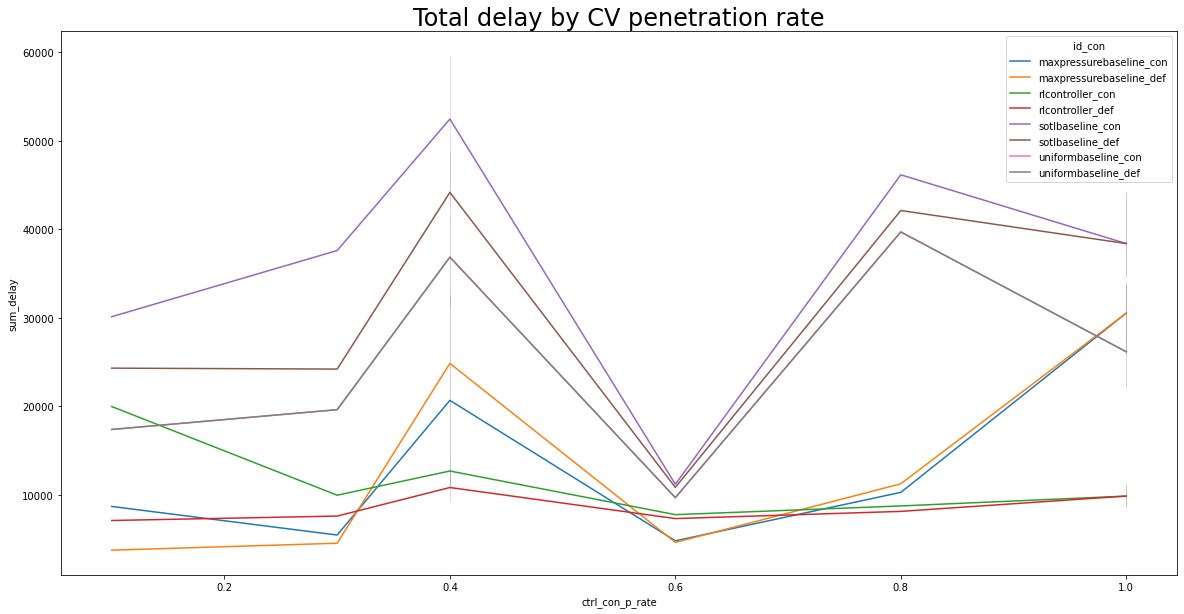

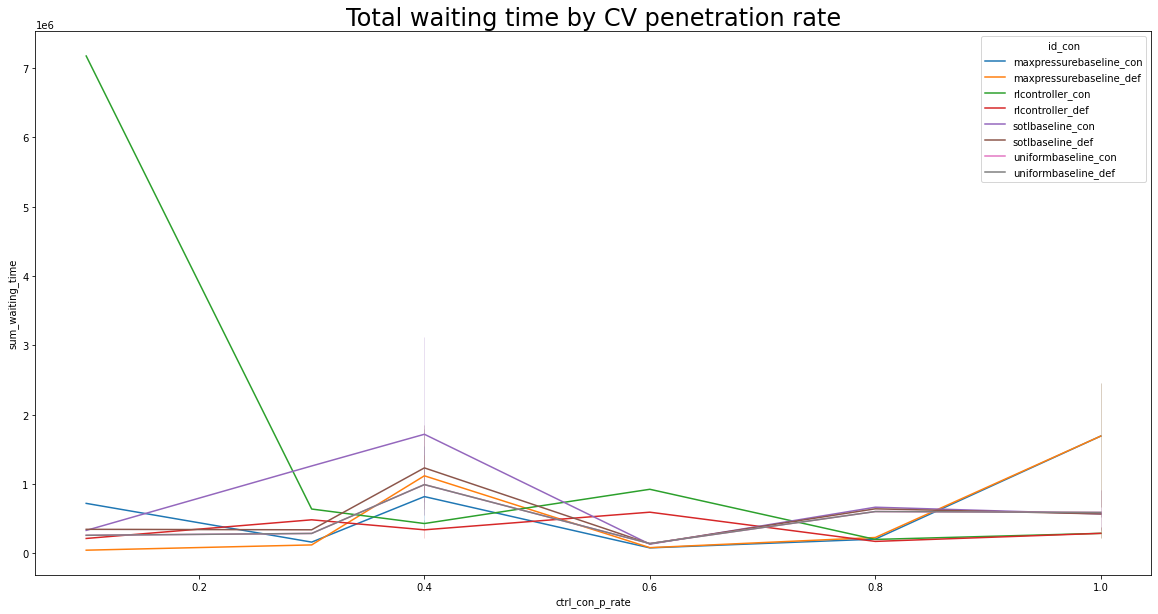

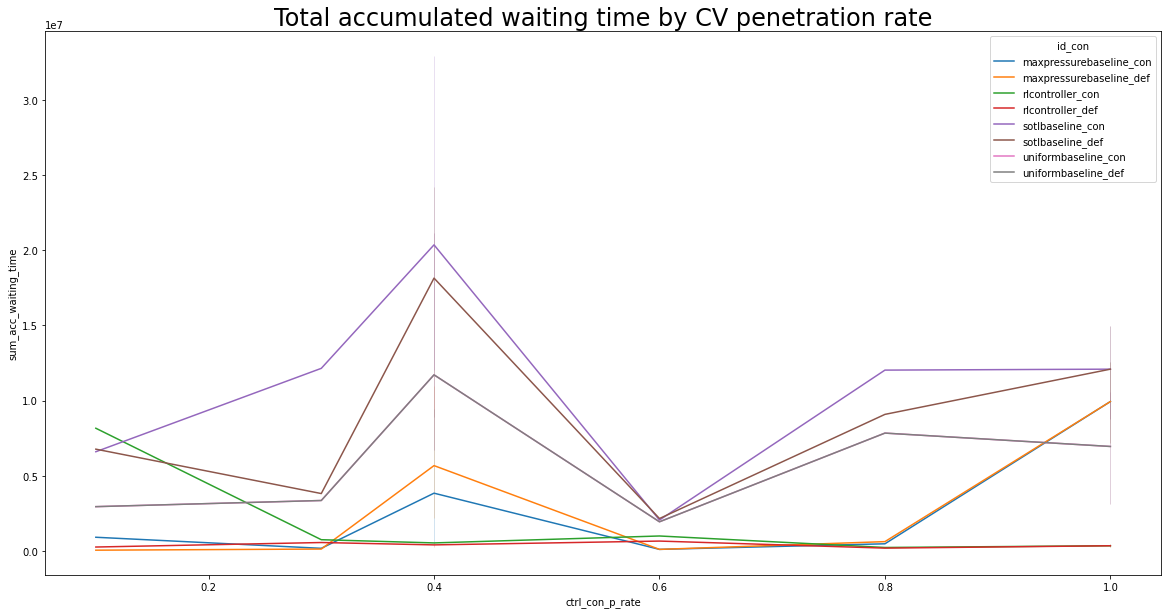

In [16]:
def plot_sum_y_by_pcon(y, title):
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=sum_df, x="ctrl_con_p_rate", y=y, hue="id_con")
    plt.title(f'Total {title} by CV penetration rate', fontsize=24)
    None

plot_sum_y_by_pcon("sum_delay", "delay")
plot_sum_y_by_pcon("sum_waiting_time", "waiting time")
plot_sum_y_by_pcon("sum_acc_waiting_time", "accumulated waiting time")